# Система музыкальных рекоммендаций

В данной задаче требуется прогнозировать вероятность повторного прослушивания песни пользователями в течение месяца после их первого прослушивания в музыкальном сервисе KKBOX. Для этого используются данные о первом прослушивании каждой уникальной пары пользователь-песня, а цель состоит в определении, будет ли происходить повторное прослушивание или нет. Это может помочь в понимании поведения пользователей и улучшении качества персонализированных рекомендаций.

## 1. Информация о предоставленных данных

### Таблица с информацией об участниках

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
members = pd.read_csv('members.csv')

In [3]:
members

,msno,city,bd,gender,registered_via,registration_init_time,expiration_date
0,XQxgAYj3klVKjR3oxPPXYYFp4soD4TuBghkhMTD4oTw=,1,0,NaN,7,20110820,20170920
1,UizsfmJb9mV54qE9hCYyU07Va97c0lCRLEQX3ae+ztM=,1,0,NaN,7,20150628,20170622
2,D8nEhsIOBSoE6VthTaqDX8U6lqjJ7dLdr72mOyLya2A=,1,0,NaN,4,20160411,20170712
3,mCuD+tZ1hERA/o5GPqk38e041J8ZsBaLcu7nGoIIvhI=,1,0,NaN,9,20150906,20150907
4,q4HRBfVSssAFS9iRfxWrohxuk9kCYMKjHOEagUMV6rQ=,1,0,NaN,4,20170126,20170613
...,...,...,...,...,...,...,...
34398,Wwd/cudKVuLJ3txRVxlg2Zaeliu+LRUfiBmfrnxhRCY=,1,0,NaN,7,20131111,20170910
34399,g3JGnJX6Hg50lFbrNWfsHwCUmApIkiv2M8sXOaeXoIQ=,4,18,male,3,20141024,20170518
34400,IMaPMJuyN+ip9Vqi+z2XuXbFAP2kbHr+EvvCNkFfj+o=,1,0,NaN,7,20130802,20170908
34401,WAnCAJjUty9Stv8yKtV7ZC7PN+ilOy5FX3aIJgGPANM=,1,0,NaN,7,20151020,20170920


Признаки:
- Идентификатор пользователя
- Город
- Возраст
- пол
- метод регистрации
- Время регистрации
- Срок действия

In [ ]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34403 entries, 0 to 34402
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   msno                    34403 non-null  object
 1   city                    34403 non-null  int64 
 2   bd                      34403 non-null  int64 
 3   gender                  14501 non-null  object
 4   registered_via          34403 non-null  int64 
 5   registration_init_time  34403 non-null  int64 
 6   expiration_date         34403 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.8+ MB


In [3]:
def convert_to_date(date_int):
    date_str = str(date_int)[:4]
    return int(date_str)

In [4]:
members['registration_year'] = members['registration_init_time'].apply(convert_to_date)
members['expiration_year'] = members['expiration_date'].apply(convert_to_date)
members = members.drop(['registration_init_time', 'expiration_date'], axis=1)

Из признаков 'registration_year' и 'expiration_year' извлечены годы регистрации и окончания срока действия, соответственно.

In [5]:
gender_dummies = pd.get_dummies(members['gender'])
members = pd.concat([members, gender_dummies], axis=1)
members = members.drop('gender', axis=1)

Из признака "gender" были созданы два новых дамми-признака для пола.

In [6]:
members['bd'] = members['bd'].apply(lambda x: 0 if x >= 100 or x < 0 else x)

Этот код заменяет значения в признаке возраста на 0 в случае, если значение в столбце больше или равно 100 или меньше 0.

In [7]:
members['membership_years'] = members['expiration_year'] - members['registration_year']

Добавлен новый признак, который указывает, в течение какого времени пользователь является участником.

### Таблица с информацией о песнях

In [8]:
songs = pd.read_csv('songs.csv')

In [10]:
songs

,song_id,song_length,genre_ids,artist_name,composer,lyricist,language
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,247640,465,張信哲 (Jeff Chang),董貞,何啟弘,3.0
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,197328,444,BLACKPINK,TEDDY| FUTURE BOUNCE| Bekuh BOOM,TEDDY,31.0
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,231781,465,SUPER JUNIOR,NaN,NaN,31.0
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,273554,465,S.H.E,湯小康,徐世珍,3.0
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,140329,726,貴族精選,Traditional,Traditional,52.0
...,...,...,...,...,...,...,...
2296315,lg6rn7eV/ZNg0+P+x77kHUL7GDMfoL4eMtXxncseLNA=,20192,958,Catherine Collard,Robert Schumann (1810-1856),NaN,-1.0
2296316,nXi1lrSJe+gLoTTNky7If0mNPrIyCQCLwagwR6XopGU=,273391,465,紀文惠 (Justine Chi),NaN,NaN,3.0
2296317,9KxSvIjbJyJzfEVWnkMbgR6dyn6d54ot0N5FKyKqii8=,445172,1609,Various Artists,NaN,NaN,52.0
2296318,UO8Y2MR2sjOn2q/Tp8/lzZTGKmLEvwZ20oWanG4XnYc=,172669,465,Peter Paul & Mary,NaN,NaN,52.0


Признаки:
- Идентификатор песни
- Длина песни: в мс
- Категория жанра: некоторые песни имеют несколько жанров и разделены знаком "|"
- Имя артиста: некоторые песни имеют несколько артистов и разделены знаком "|"
- Композитор: некоторые песни имеют несколько композиторов и разделены знаком "|"
- Автор текстов
- Язык

In [11]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [12]:
songs.isna().sum()

song_id              0
song_length          0
genre_ids        94116
artist_name          0
composer       1071354
lyricist       1945268
language             1
dtype: int64

In [9]:
songs['language'].dropna(inplace=True)

Удалены пропуски из признака 'language'.

In [14]:
songs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2296320 entries, 0 to 2296319
Data columns (total 7 columns):
 #   Column       Dtype  
---  ------       -----  
 0   song_id      object 
 1   song_length  int64  
 2   genre_ids    object 
 3   artist_name  object 
 4   composer     object 
 5   lyricist     object 
 6   language     float64
dtypes: float64(1), int64(1), object(5)
memory usage: 122.6+ MB


In [10]:
gnr_list = songs['genre_ids'].dropna().str.split('|')
genre_counts = {}

for genres in gnr_list:
    for genre in genres:
        if genre in genre_counts:
            genre_counts[genre] += 1
        else:
            genre_counts[genre] = 1

top_5_genres = sorted(genre_counts, key=genre_counts.get, reverse=True)[:5]

for genre in top_5_genres:
    songs[f'genre_{genre}'] = songs['genre_ids'].fillna('').str.contains(genre).astype(int)

Добавлены 5 новых дамми-признаков для пяти наиболее популярных жанров.

In [11]:
comp_list = songs['composer'].dropna().str.split('|')
comp_counts = {}

for comps in comp_list:
    for comp in comps:
        if comp in comp_counts:
            comp_counts[comp] += 1
        else:
            comp_counts[comp] = 1

top_5_composers = sorted(comp_counts, key=comp_counts.get, reverse=True)[:5]

for i in top_5_composers:
    songs[f'{i}'] = songs['composer'].fillna('').str.contains(i).astype(int)

In [12]:
lyr_list = songs['lyricist'].dropna().str.split('|')
lyr_counts = {}

for lyrics in lyr_list:
    for lyr in lyrics:
        if lyr in lyr_counts:
            lyr_counts[lyr] += 1
        else:
            lyr_counts[lyr] = 1

top_5_lyricists = sorted(lyr_counts, key=lyr_counts.get, reverse=True)[:5]

for i in top_5_lyricists:
    songs[f'{i}'] = songs['lyricist'].fillna('').str.contains(i).astype(int)

Аналогично для признаков 'composer' и 'lyricist'.

### Таблица с дополнительной информацией о песнях

In [13]:
song_extra = pd.read_csv('song_extra_info.csv')

In [14]:
song_extra

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001
...,...,...,...
2295966,hLnetpF6UbPg28sSfXnPE2vsdaGsLvddlXEdJR4VTIA=,Deep Breathing,PLL431720793
2295967,N+6vJ8actKQm0S3Fpf4elipTjoAo9ev28aA5FJN5e40=,In Hiding,US5UL1519827
2295968,pv35uG0ts05mWtirM/AMOWEzbHxIVart5ZzRXqKUY1c=,Il Est Ne Le Divin Enfant,PLL431502294
2295969,QSySnm8jt2Go7byY34/PxsZP6dPCins2j2cyYquNhBo=,The Exodus Song,DEPZ69316095


Признаки:
- Идентификатор песни
- Название песни
- Международный стандартный код записи

In [15]:
song_extra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2295971 entries, 0 to 2295970
Data columns (total 3 columns):
 #   Column   Dtype 
---  ------   ----- 
 0   song_id  object
 1   name     object
 2   isrc     object
dtypes: object(3)
memory usage: 52.6+ MB


In [21]:
song_extra.isna().sum()

song_id         0
name            2
isrc       136548
dtype: int64

In [14]:
def get_year(isrc):
    if pd.isnull(isrc):
        return int(0)
    else:
        if int(str(isrc)[5:7]) > 17:
            year =  1900+int(str(isrc)[5:7])
        else:
            year = 2000+int(isrc[5:7])
        return int(year)

In [15]:
song_extra['year'] = song_extra['isrc'].apply(lambda x: get_year(x))

Добавлен новый признак - год выпуска песни, извлеченный из признака Международного стандартного кода записи.

In [16]:
def get_country(isrc):
    if pd.isna(isrc):
        return str('')
    else:
        return str(isrc[:2])

In [17]:
song_extra['country_code'] = song_extra['isrc'].apply(lambda x: get_country(x))

Добавлен новый признак - код страны, выпустившей песню, извлеченный из признака Международного стандартного кода записи.

In [18]:
songs = songs.merge(song_extra, how='left', on='song_id')

К таблице "songs" присоединена таблица "song_extra".

### Обучающие и тестовые данные

In [19]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [20]:
train

,msno,song_id,source_system_tab,source_screen_name,source_type,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1
...,...,...,...,...,...,...
7377413,6xdFzPlrasIDD95mQWXVC3Bg4ptnGYtBl4ztVEZMddU=,VJTxizih/o28kXCbtPbIyWXScoXGvxyYtl6R+0YB5JM=,my library,Local playlist more,local-playlist,1
7377414,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,z1mqaU9YOX7T/PFDvUoWozdFq7rC3KwaQP7nFVprjMI=,search,Search,song,0
7377415,ZxbVmt3Kh/XOH+h58c2Kdj6SjFZk+wnUO006IgWzMQE=,750RprmFfLV0bymtDH88g24pLZGVi5VpBAI300P6UOA=,search,Search,song,1
7377416,0aH4Hd3ziPSRHClRX8rkeOEaAG5EPPkW1mKGCdXEok0=,G8wgqObgeAMER/rVCIlgcNeQ8mm0CzF/GsxiMK8TTnA=,discover,Discover Genre,online-playlist,1


Признаки:
- Идентификатор пользователя
- Идентификатор песни
- source_system_tab: Имя вкладки, на которой было вызвано событие. Например, вкладка «Моя библиотека» содержит функции для управления локальным хранилищем, а вкладка «Поиск» содержит функции, относящиеся к поиску.
- source_screen_name: имя макета, который видит пользователь.
- source_type: точка входа, где пользователь впервые воспроизводит музыку в мобильных приложениях. Точкой входа может быть альбом, онлайн-плейлист, песня и т. д.
- Целевая переменная. target=1 означает, что в течение месяца после самого первого наблюдаемого пользователем прослушивания происходят повторяющиеся события прослушивания, в противном случае target=0.

In [29]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377418 entries, 0 to 7377417
Data columns (total 6 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   msno                object
 1   song_id             object
 2   source_system_tab   object
 3   source_screen_name  object
 4   source_type         object
 5   target              int64 
dtypes: int64(1), object(5)
memory usage: 337.7+ MB


In [30]:
train.isna().sum()

msno                       0
song_id                    0
source_system_tab      24849
source_screen_name    414804
source_type            21539
target                     0
dtype: int64

In [20]:
train['source_screen_name'] = train['source_screen_name'].fillna('Unknown')

Строки в признаке 'source_screen_name' заполнены значением 'Unknown', если в них присутствуют пропущенные значения.

In [21]:
train['source_type'] = train.groupby('msno')['source_type'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)

Пропуски в признаке точка входа заполнены самым часто встречающимся значением.

In [88]:
train['source_system_tab'].isna().sum() / len(train)

0.0030963380434340833

In [22]:
train.dropna(subset=['source_system_tab'], inplace=True)

Пропущенные значения в признаке "source_system_tab" удалены, так как они составляют менее 10% от объема всех данных.

In [23]:
def merged_data(data, members, songs):
    data = data.merge(members, how='left', on='msno')
    data = data.merge(songs, how='left', on='song_id')
    return data

In [24]:
data_train = merged_data(train, members, songs)

Данные объединены в общую таблицу.

In [92]:
data_train.duplicated().sum()

0

В данных не обнаружено дубликатов.

In [27]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7352569 entries, 0 to 7352568
Data columns (total 38 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   msno                     object 
 1   song_id                  object 
 2   source_system_tab        object 
 3   source_screen_name       object 
 4   source_type              object 
 5   target                   int64  
 6   city                     int64  
 7   bd                       int64  
 8   registered_via           int64  
 9   registration_year        int64  
 10  expiration_year          int64  
 11  female                   uint8  
 12  male                     uint8  
 13  membership_years         int64  
 14  song_length              float64
 15  genre_ids                object 
 16  artist_name              object 
 17  composer                 object 
 18  lyricist                 object 
 19  language                 float64
 20  genre_465                float64
 21  genre_95

In [28]:
data_train.isna().sum()

msno                             0
song_id                          0
source_system_tab                0
source_screen_name               0
source_type                     12
target                           0
city                             0
bd                               0
registered_via                   0
registration_year                0
expiration_year                  0
female                           0
male                             0
membership_years                 0
song_length                    114
genre_ids                   118098
artist_name                    114
composer                   1670541
lyricist                   3168953
language                       150
genre_465                      114
genre_958                      114
genre_1609                     114
genre_2022                     114
genre_2122                     114
Neuromancer                    114
Johann Sebastian Bach          114
Wolfgang Amadeus Mozart        114
Traditional         

После присоединения таблиц появились новые пропуски.

In [25]:
df_gnr = data_train.copy()
genre_df = data_train['genre_ids'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).rename('fav_genre')

df_gnr = df_gnr.drop(columns='genre_ids').join(genre_df)
genre_counts = df_gnr.groupby(['msno', 'fav_genre']).size().reset_index(name='count')
favorite_genres = genre_counts.loc[genre_counts.groupby('msno')['count'].idxmax()]
favorite_genres.drop('count', axis=1)

data_train = data_train.merge(favorite_genres[['msno', 'fav_genre']], how='left', on='msno')

Добавлен новый признак, отражающий любимый жанр для каждого пользователя.

In [26]:
data_train['artist_name'] = data_train['artist_name'].fillna('Unknown')

Строки в столбце 'artist_name' заполнены значениями 'Unknown', если в них есть пропуски.

In [27]:
data_train['language'] = data_train.groupby('artist_name')['language'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)
data_train.dropna(subset='language', inplace=True)

Пропуски в признаке 'language' заполнены самым часто встречающимся значением, сгруппированным по имени артиста. Оставшиеся пропуски удалены.

In [28]:
data_train['country_code'] = data_train.groupby('language')['country_code'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)

Пропуски в признаке Кода заполнены самым часто встречающимся значением, сгруппированным по признаку языка. Оставшиеся пропуски удалены.

In [29]:
threshold = 100

artist_counts = data_train['artist_name'].value_counts()

data_train['popular_artist'] = data_train['artist_name'].map(artist_counts) >= threshold

data_train['popular_artist'] = data_train['popular_artist'].astype(int)

Добавлен новый признак 'popular_artist', который указывает, является ли артист популярным или нет, на основе количества его упоминаний в столбце 'artist_name'.

In [30]:
data_train['year'] = data_train['year'].fillna(0)

Пропуски в признаке "year" в таблице train были заполнены нулями из-за отсутствия значений в признаке "isrc", который использовался для заполнения признака "year".

In [31]:
data_train['fav_genre'] = data_train['fav_genre'].fillna(top_5_genres[0])

Пропуски в признаке 'fav_genre' заполнены самым популярным жанром среди слушателей.

In [32]:
data_train.dropna(subset='source_type', inplace=True)

Пропущенные значения в признаке 'source_type' удалены.

In [33]:
data_train.drop(['artist_name', 'name', 'isrc', 'genre_ids', 'composer', 'lyricist'], axis=1, inplace=True)

Признаки 'artist_name', 'name', 'isrc', 'genre_ids', 'composer', 'lyricist' были удалены, поскольку они не несут значимой информации в данном контексте.

In [104]:
data_train.isna().sum()

msno                       0
song_id                    0
source_system_tab          0
source_screen_name         0
source_type                0
target                     0
city                       0
bd                         0
registered_via             0
registration_year          0
expiration_year            0
female                     0
male                       0
membership_years           0
song_length                0
language                   0
genre_465                  0
genre_958                  0
genre_1609                 0
genre_2022                 0
genre_2122                 0
Neuromancer                0
Johann Sebastian Bach      0
Wolfgang Amadeus Mozart    0
Traditional                0
Marco Rinaldo              0
―                          0
林夕                         0
Michael Ruland             0
 Jr.                       0
year                       0
country_code               0
fav_genre                  0
popular_artist             0
dtype: int64

### 2. Анализ данных

In [38]:
data_train.describe()

,target,city,bd,registered_via,registration_year,expiration_year,female,male,membership_years,song_length,...,Johann Sebastian Bach,Wolfgang Amadeus Mozart,Traditional,Marco Rinaldo,―,林夕,Michael Ruland,Jr.,year,popular_artist
count,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,...,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06,7.352443e+06
mean,5.034960e-01,7.506297e+00,1.723944e+01,6.793165e+00,2.012742e+03,2.017072e+03,2.868837e-01,3.114213e-01,4.330052e+00,2.451168e+05,...,4.651515e-04,6.344830e-04,2.644019e-04,5.127547e-05,3.182616e-05,6.933070e-03,1.632111e-05,1.839933e-03,1.853642e+03,9.501830e-01
std,4.999878e-01,6.638576e+00,1.557864e+01,2.275608e+00,3.018890e+00,3.966111e-01,4.523068e-01,4.630746e-01,3.081067e+00,6.737429e+04,...,2.156236e-02,2.518096e-02,1.625829e-02,7.160506e-03,5.641378e-03,8.297592e-02,4.039906e-03,4.285496e-02,5.405118e+02,2.175668e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,3.000000e+00,2.004000e+03,2.004000e+03,0.000000e+00,0.000000e+00,0.000000e+00,1.393000e+03,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,0.000000e+00,4.000000e+00,2.011000e+03,2.017000e+03,0.000000e+00,0.000000e+00,2.000000e+00,2.147260e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.007000e+03,1.000000e+00
50%,1.000000e+00,5.000000e+00,2.100000e+01,7.000000e+00,2.013000e+03,2.017000e+03,0.000000e+00,0.000000e+00,4.000000e+00,2.417890e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.013000e+03,1.000000e+00
75%,1.000000e+00,1.300000e+01,2.900000e+01,9.000000e+00,2.015000e+03,2.017000e+03,1.000000e+00,1.000000e+00,6.000000e+00,2.721430e+05,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.016000e+03,1.000000e+00
max,1.000000e+00,2.200000e+01,9.500000e+01,1.300000e+01,2.017000e+03,2.020000e+03,1.000000e+00,1.000000e+00,1.400000e+01,1.085171e+07,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.017000e+03,1.000000e+00


In [46]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

In [47]:
num_col = data_train.select_dtypes(include=['int', 'float']).drop('target', axis=1).columns

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_train[num_col]))

Top Absolute Correlations
registration_year  membership_years           0.991752
city               bd                         0.537519
bd                 membership_years           0.454142
registered_via     membership_years           0.444543
                   registration_year          0.442592
bd                 registration_year          0.441553
city               membership_years           0.293659
                   registration_year          0.279880
genre_958          Wolfgang Amadeus Mozart    0.262760
language           genre_1609                 0.258139
dtype: float64


Наиболее скореллированные признаки - год регистрации и срок участия, менее скореллированные город и возраст, а так же композиторы и авторы текста.

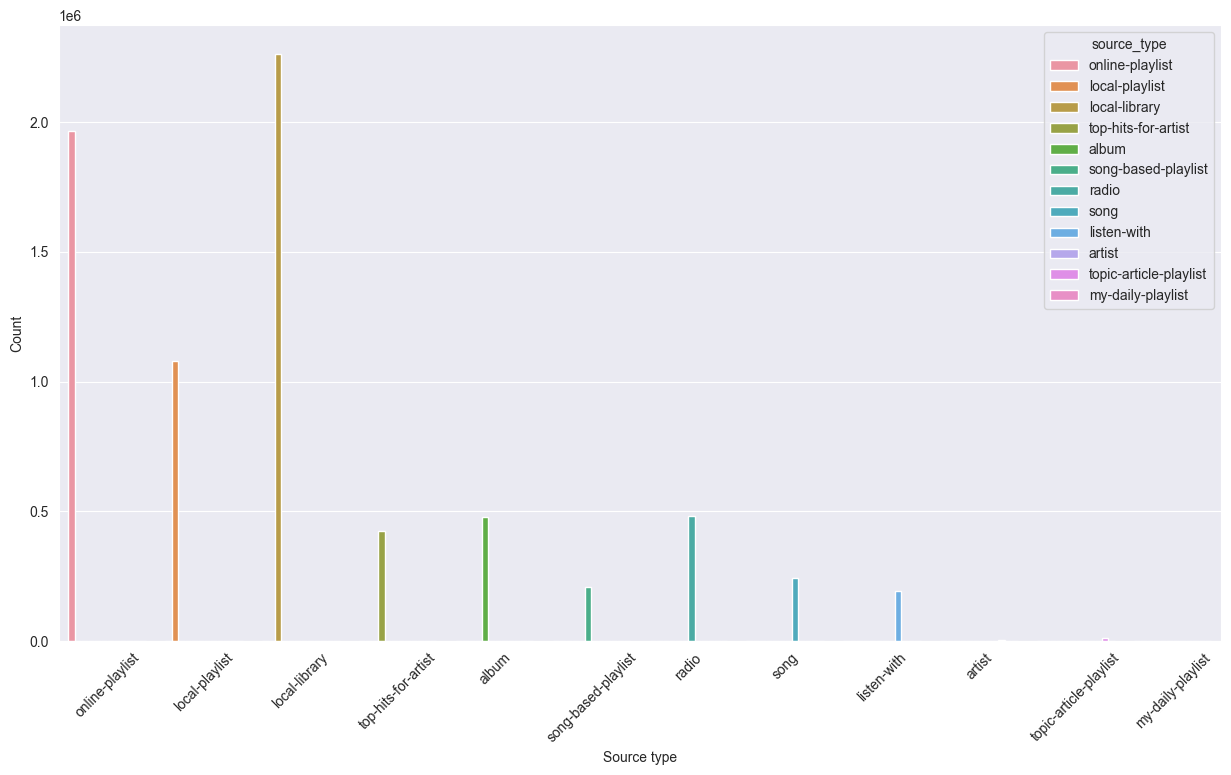

In [ ]:
plt.figure(figsize=(15, 8))
sns.countplot(x='source_type',hue='source_type',data=data_train)
plt.xticks(rotation=45)
plt.xlabel('Source type')
plt.ylabel('Count')
plt.show()

Точкой входа для большинства пользователей является их локальная библиотека, на втором месте - онлайн плейлисты. Это может говорить о том, что большая часть пользователей заходят в сервис для прослушивания музыки из своего альбома и меньше интересуются радио и системой похожих песен. Это значит, что большинство пользователей расположены к рекомендациям на основе уже выбранной и понравившейся им музыке, реже привержены к случайным жанрам и форматам(которые могут появиться на радио, так как радио, вероятнее всего, устроено на рандомизированном подборе музыки)

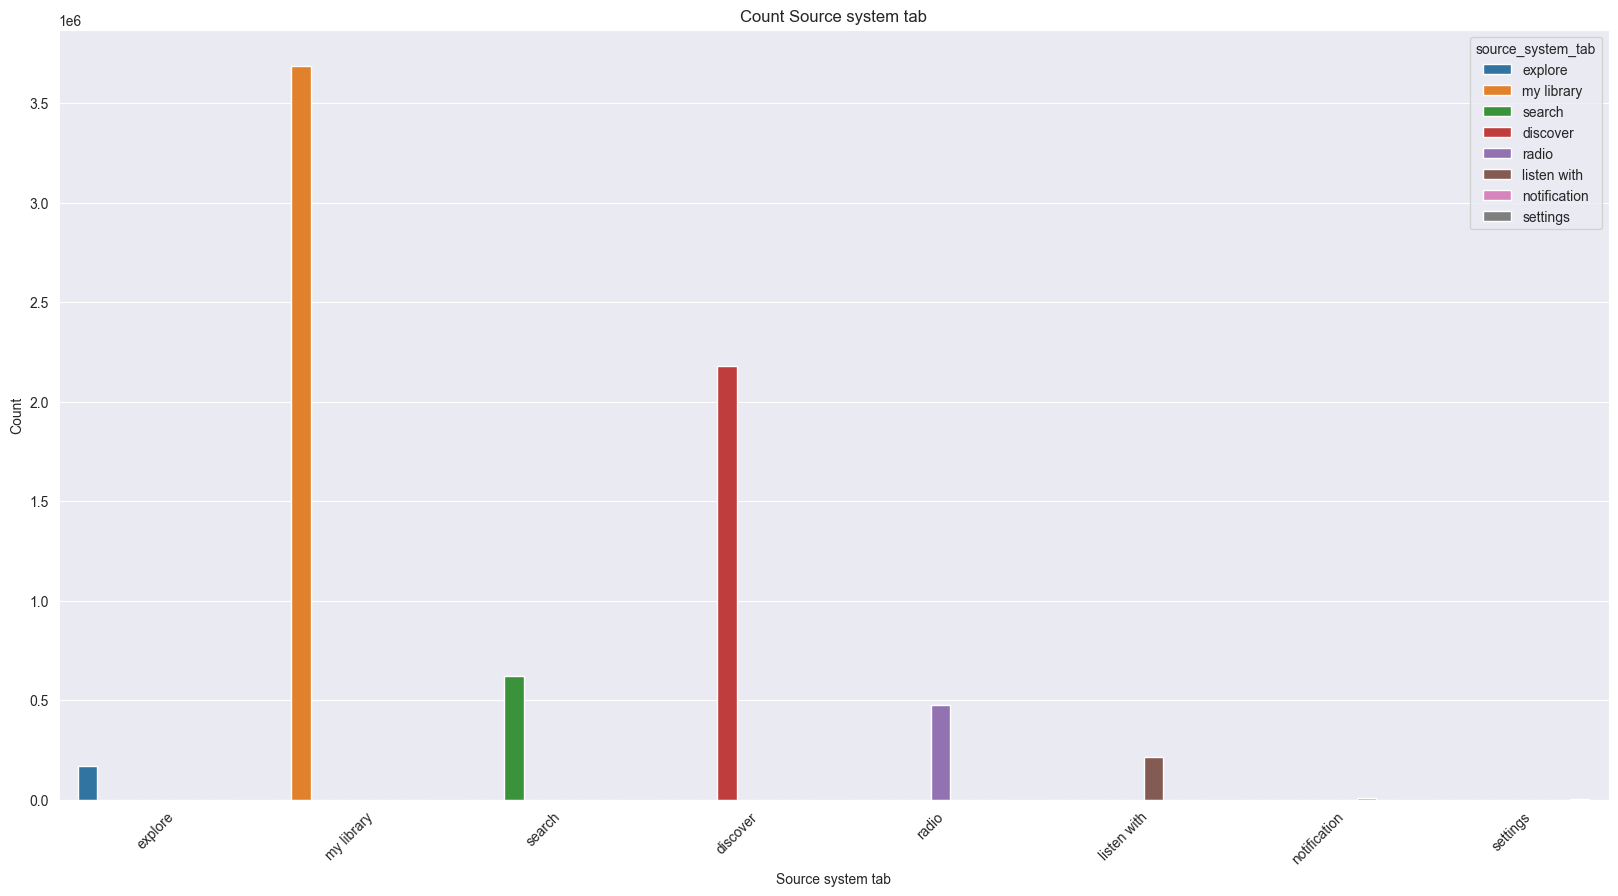

In [ ]:
plt.figure(figsize=(20, 10))
sns.countplot(x='source_system_tab',hue='source_system_tab',data=data_train)
plt.xticks(rotation=45)
plt.title('Count Source system tab')
plt.xlabel('Source system tab')
plt.ylabel('Count')
plt.show()

Чаще всего пользователи запускают событие из своей библиотеки, на втором месте - найденная по запросу песня.

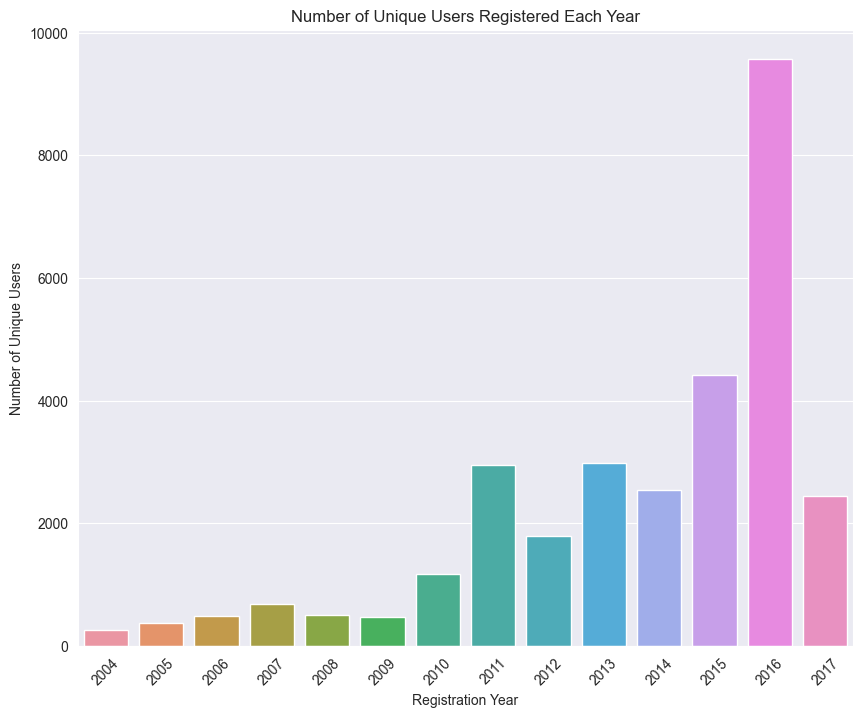

In [ ]:
users_per_year = data_train.groupby('registration_year')['msno'].nunique().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x='registration_year', y='msno', data=users_per_year)
plt.title('Number of Unique Users Registered Each Year')
plt.xlabel('Registration Year')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.show()

Большее число пользователей зарегистрировалось в 2016 году. Начиная с 2011 года, наблюдается рост числа зарегистрированных пользователей, что может быть связано с увеличением популярности сервиса.

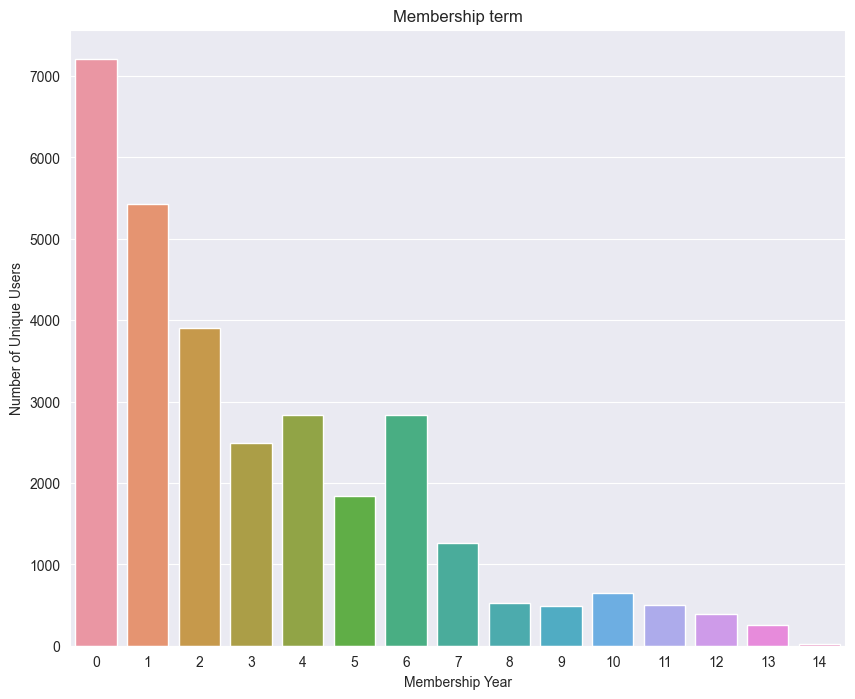

In [ ]:
users_per_membership = data_train.groupby('membership_years')['msno'].nunique().reset_index()

plt.figure(figsize=(10, 8))
sns.barplot(x='membership_years', y='msno', data=users_per_membership)
plt.title('Membership term')
plt.xlabel('Membership Year')
plt.ylabel('Number of Unique Users')
plt.show()

По мере увеличения срока пользования сервисом, количество активных пользователей снижается. Этот паттерн может указывать на то, что пользователи, зарегистрировавшиеся позже 2011, склонны оставаться активными пользователями. Можно предположить, что пользователи, зарегистрировавшиеся 6 лет назад, остались активными пользователями сервиса, однако, необходимо учитывать и появление значительного числа новых пользователей, начиная с 2011, что может влиять на общее количество активных пользователей.

In [41]:
print(data_train['target'].value_counts()[0] / len(data_train))
print(data_train['target'].value_counts()[1] / len(data_train))

0.49650395113569734
0.5034960488643027


Целевая переменная близка к балансу классов, поэтому выбрана метрика качества roc auc.

## 3. Обучение моделей

In [48]:
data_train = data_train.set_index(['msno', 'song_id'])

In [49]:
def probs(X, y, model, top = 20):

    indexes_u = [x[0] for x in X.index.values.tolist()]
    indexes_s = [x[1] for x in X.index.values.tolist()]

    res = model.predict_proba(X)
    res[:, 1].tolist()

    predictions_df = pd.DataFrame({
        'msno': indexes_u,
        'song_id': indexes_s,
        'recommendation_proba': res[:, 1],
        'target': y.tolist()
    }).sort_values(by='msno', ascending=False)

    def sorted_prob(group):
        group = group.nlargest(top, 'recommendation_proba')
        return group

    predictions_df_group = predictions_df.groupby('msno').apply(sorted_prob)
    predictions_df_group = predictions_df_group.reset_index(drop=True)

    return predictions_df_group

In [50]:
def ndcg_at_k(preds_df):
    ndcg_val = []

    def penalty_score(position):
        return 1 / np.log2(position + 2)

    def ndcg_user(ratings):
        sorted_ratings = np.sort(ratings)[::-1]
        dcg = np.sum(sorted_ratings * penalty_score(np.arange(len(sorted_ratings))))
        idcg = np.sum(np.sort(penalty_score(np.arange(len(ratings))))[::-1])
        if idcg == 0:
            return 0
        else:
            ndcg = dcg / idcg
        return ndcg

    for user_id, group in preds_df.groupby('msno'):
        ndcg = ndcg_user(group['target'])
        ndcg_val.append(ndcg)

    return np.mean(ndcg_val)

Функция, в которой реализована метрика качества NDCG@k.

In [51]:
data_split_train = data_train[:5514419]
data_split_test = data_train[5514419:]

In [52]:
len(data_split_train) / len(data_train)

0.7500117987993923

Обучающие данные разделены на обучающую и тестовую выборки в соотношении 75:25

In [53]:
X_train, X_test = data_split_train.drop('target', axis=1), data_split_test.drop('target', axis=1)
y_train, y_test = data_split_train['target'], data_split_test['target']

Logloss выбран для функции потерь в обучении модели из-за его способности оценивать вероятности классов и обеспечивать дифференцируемость, что делает его идеальным выбором для оптимизации параметров модели с помощью градиентного спуска.

In [111]:
from catboost import CatBoostClassifier

In [130]:
cb_def = CatBoostClassifier(random_state=45, iterations=50, cat_features=list(data_train.select_dtypes(include='object')),  loss_function='Logloss')
cb_def.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.5855022	total: 1.98s	remaining: 1m 36s
1:	learn: 0.5604367	total: 3.18s	remaining: 1m 16s
2:	learn: 0.5541487	total: 4.42s	remaining: 1m 9s
3:	learn: 0.5515302	total: 5.75s	remaining: 1m 6s
4:	learn: 0.5501814	total: 7.31s	remaining: 1m 5s
5:	learn: 0.5491198	total: 8.82s	remaining: 1m 4s
6:	learn: 0.5484100	total: 10.4s	remaining: 1m 3s
7:	learn: 0.5478699	total: 12s	remaining: 1m 3s
8:	learn: 0.5475841	total: 13.5s	remaining: 1m 1s
9:	learn: 0.5469669	total: 15s	remaining: 59.8s
10:	learn: 0.5464805	total: 16.6s	remaining: 58.8s
11:	learn: 0.5458492	total: 17.9s	remaining: 56.5s
12:	learn: 0.5453413	total: 18.7s	remaining: 53.1s
13:	learn: 0.5450821	total: 19.4s	remaining: 50s
14:	learn: 0.5447950	total: 20.2s	remaining: 47.1s
15:	learn: 0.5441814	total: 21s	remaining: 44.6s
16:	learn: 0.5437479	total: 21.8s	remaining: 42.3s
17:	learn: 0.5433445	total: 22.5s	remaining: 40.1s
18:	learn: 0.5429132	total: 23.3s	remaining: 37.9s
19:	learn: 0.5427220	t

In [54]:
from sklearn.metrics import roc_auc_score, classification_report

In [131]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, cb_def.predict_proba(X_train)[:,1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, cb_def.predict_proba(X_test)[:,1])}')

ROC-AUC TRAIN: 0.7437142388587371
ROC-AUC TEST: 0.7132563476089739


Значение ROC-AUC на обучающем наборе данных составляет 0.7437, указывая на хорошую способность модели разделять классы. На тестовом наборе данных значение ROC-AUC равно 0.7133, что подтверждает хорошее обобщение модели на новых данных.

In [132]:
print('Train:')
print(classification_report(y_train, cb_def.predict(X_train)))
print('Test:')
print(classification_report(y_test, cb_def.predict(X_test)))

Train:
              precision    recall  f1-score   support

         0.0       0.64      0.40      0.49    345642
         1.0       0.77      0.90      0.83    758108

    accuracy                           0.74   1103750
   macro avg       0.71      0.65      0.66   1103750
weighted avg       0.73      0.74      0.72   1103750

Test:
              precision    recall  f1-score   support

         0.0       0.66      0.42      0.51    144356
         1.0       0.70      0.86      0.77    223560

    accuracy                           0.69    367916
   macro avg       0.68      0.64      0.64    367916
weighted avg       0.68      0.69      0.67    367916


На обучающем наборе данных модель достигает точности 0.74 с f1-мерой для класса 1.0 равной 0.83 и f1-мерой для класса 0.0 равной 0.49. На тестовом наборе данных точность составляет 0.69 с f1-мерой для класса 1.0 равной 0.77 и f1-мерой для класса 0.0 равной 0.51. Обобщая, модель имеет хорошую способность предсказывать положительные классы, но менее точно предсказывает отрицательные классы.

In [133]:
prediction_train_cb = probs(X_train, y_train, cb_def)
prediction_test_cb = probs(X_test, y_test, cb_def)

In [135]:
cb_train_ndcg = ndcg_at_k(prediction_train_cb)
cb_test_ndcg = ndcg_at_k(prediction_test_cb)

print(f'NDCG@20 in train: {cb_train_ndcg}')
print(f'NDCG@20 in test: {cb_test_ndcg}')

NDCG@20 in train: 0.7597844228926831
NDCG@20 in test: 0.7187524527892477


Модель показывает хорошие способности в ранжировании рекомендаций на обучающем наборе данных (NDCG@20 = 0.7598) и на тестовом (NDCG@20 = 0.7188).

In [136]:
from lightgbm import LGBMClassifier

In [55]:
obj_cols = X_train.select_dtypes(include='object').columns.tolist()
X_train_cat, X_test_cat = X_train.copy(), X_test.copy()
X_train_cat[obj_cols] = X_train_cat[obj_cols].astype('category')
X_test_cat[obj_cols] = X_test_cat[obj_cols].astype('category')

Преобразование признаков типа "object" в категориальные признаки. Это необходимо для обучения LGBM и XGBOOST моделей.

In [137]:
lgbm_def = LGBMClassifier(n_estimators=50, objective='binary', metric='binary_logloss')
lgbm_def.fit(X_train_cat, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 758108, number of negative: 345642
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.163078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 658
[LightGBM] [Info] Number of data points in the train set: 1103750, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.686848 -> initscore=0.785422
[LightGBM] [Info] Start training from score 0.785422


LGBMClassifier(metric='binary_logloss', n_estimators=50, objective='binary')

In [138]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, lgbm_def.predict_proba(X_train_cat)[:, 1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, lgbm_def.predict_proba(X_test_cat)[:, 1])}')

ROC-AUC TRAIN: 0.7398078387697739
ROC-AUC TEST: 0.7143818561645136


Значение ROC-AUC на обучающем наборе данных составляет 0.7398, что указывает на хорошую способность модели разделять классы. На тестовом наборе данных значение ROC-AUC равно 0.7144, что также свидетельствует о хорошем качестве модели в обобщении на новые данные. Относительно модели catboost, lgbm показывает чуть лучшие результаты предсказания классаю

In [139]:
print('Train:')
print(classification_report(y_train, lgbm_def.predict(X_train_cat)))
print('Test:')
print(classification_report(y_test, lgbm_def.predict(X_test_cat)))

Train:
              precision    recall  f1-score   support

         0.0       0.64      0.41      0.50    345642
         1.0       0.77      0.89      0.83    758108

    accuracy                           0.74   1103750
   macro avg       0.70      0.65      0.66   1103750
weighted avg       0.73      0.74      0.72   1103750

Test:
              precision    recall  f1-score   support

         0.0       0.66      0.43      0.52    144356
         1.0       0.70      0.85      0.77    223560

    accuracy                           0.69    367916
   macro avg       0.68      0.64      0.65    367916
weighted avg       0.68      0.69      0.67    367916


По сравнению с предыдущей моделью, новая модель на обучающем наборе данных также демонстрирует высокую точность (0.74) и f1-меру для класса 1.0 (0.83), однако f1-мера для класса 0.0 увеличилась до 0.50. На тестовом наборе данных точность модели осталась на прежнем уровне (0.69), но f1-мера для класса 1.0 увеличилась до 0.77, а для класса 0.0 - до 0.52.

In [140]:
prediction_train_lgbm = probs(X_train_cat, y_train, lgbm_def)
prediction_test_lgbm = probs(X_test_cat, y_test, lgbm_def)

In [141]:
lgbm_train_ndcg = ndcg_at_k(prediction_train_lgbm)
lgbm_test_ndcg = ndcg_at_k(prediction_test_lgbm)

print(f'NDCG@20 in train: {lgbm_train_ndcg}')
print(f'NDCG@20 in test: {lgbm_test_ndcg}')

NDCG@20 in train: 0.7600054400223965
NDCG@20 in test: 0.7187293374744734


Значение метрики NDCG@20 для обучающего набора данных составляет 0.7600, а для тестового - 0.7187. Эти значения указывают на высокое качество ранжирования предсказаний модели, учитывая как их порядок, так и их релевантность для пользователей. Однако, модель catboost показала себя лучше в результатах ранжирования.

In [56]:
from xgboost import XGBClassifier

In [142]:
xgb_def = XGBClassifier(random_state=45, enable_categorical=True, tree_method='hist',objective='binary:logistic', n_estimators=50)
xgb_def.fit(X_train_cat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, random_state=45, ...)

In [143]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, xgb_def.predict_proba(X_train_cat)[:, 1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, xgb_def.predict_proba(X_test_cat)[:, 1])}')

ROC-AUC TRAIN: 0.7576931395321789
ROC-AUC TEST: 0.7186431443292857


начение ROC-AUC на обучающем наборе данных для данной модели составляет 0.7577, а на тестовом - 0.7186. Эти результаты указывают на то, что данная модель демонстрирует хорошую способность разделять классы как на обучающем, так и на тестовом наборе данных. По сравнению с моделью lgbm, модель xgboost показывает улучшение на тестовых данных, однако, в сравнении с моделью catboost ухудшение.

In [144]:
print('Train:')
print(classification_report(y_train, xgb_def.predict(X_train_cat)))
print('Test:')
print(classification_report(y_test, xgb_def.predict(X_test_cat)))

Train:
              precision    recall  f1-score   support

         0.0       0.67      0.42      0.52    345642
         1.0       0.78      0.91      0.84    758108

    accuracy                           0.75   1103750
   macro avg       0.72      0.66      0.68   1103750
weighted avg       0.74      0.75      0.74   1103750

Test:
              precision    recall  f1-score   support

         0.0       0.67      0.43      0.52    144356
         1.0       0.70      0.86      0.77    223560

    accuracy                           0.69    367916
   macro avg       0.68      0.65      0.65    367916
weighted avg       0.69      0.69      0.67    367916


По сравнению с предыдущими моделями xgboost показывает лучшие показатели.

In [145]:
prediction_train_xgb = probs(X_train_cat, y_train, xgb_def)
prediction_test_xgb = probs(X_test_cat, y_test, xgb_def)

In [146]:
xgb_train_ndcg = ndcg_at_k(prediction_train_xgb)
xgb_test_ndcg = ndcg_at_k(prediction_test_xgb)

print(f'NDCG@20 in train: {xgb_train_ndcg}')
print(f'NDCG@20 in test: {xgb_test_ndcg}')

NDCG@20 in train: 0.7645757102842604
NDCG@20 in test: 0.7194129184655454



Модель XGBoost была выбрана за ее выдающееся качество ранжирования и высокую точность предсказаний целевой переменной, что делает ее оптимальным выбором для решения данной задачи.

In [156]:
from sklearn.model_selection import GridSearchCV

In [158]:
param_grid = {
    'learning_rate': [0.01, 0.05],
    'max_depth': [4, 6],
    'n_estimators': [100, 200, 300]
}

xgboost = XGBClassifier(random_state=45, enable_categorical=True, tree_method='hist', objective='binary:logistic')

grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, scoring='neg_log_loss', verbose=3)
grid_search.fit(X_train_cat, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-0.559 total time=  27.8s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-0.563 total time=  24.3s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-0.564 total time=  24.3s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-0.567 total time=  23.5s
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=100;, score=-0.564 total time=  26.2s
[CV 1/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=-0.546 total time=  43.9s
[CV 2/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=-0.553 total time=  45.4s
[CV 3/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=-0.553 total time=  41.3s
[CV 4/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, score=-0.558 total time= 1.2min
[CV 5/5] END learning_rate=0.01, max_depth=4, n_estimators=200;, s

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=True, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bi...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=45, ...),
             param_grid={'learning_rate': [0.01, 0.05], 'max_depth': [4, 6],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_log_loss', verbose=3)

In [159]:
grid_search.best_params_

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 300}

Поиск оптимальных параметров для модели XGBoost.

In [57]:
xgboost = XGBClassifier(random_state=45, enable_categorical=True, tree_method='hist', objective='binary:logistic', n_estimators=300, max_depth=6, learning_rate=0.05)
xgboost.fit(X_train_cat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=45, ...)

In [161]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, xgboost.predict_proba(X_train_cat)[:,1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, xgboost.predict_proba(X_test_cat)[:,1])}')

ROC-AUC TRAIN: 0.7577323396106376
ROC-AUC TEST: 0.7195276469290467


Модель достигает значения ROC-AUC 0.7577 на обучающем наборе данных и 0.7195 на тестовом наборе данных. Эти значения чуть выше, чем у предыдущей модели XGBoost (0.7577 на обучающем наборе и 0.7186 на тестовом наборе).

In [162]:
print('Train:')
print(classification_report(y_train, xgboost.predict(X_train_cat)))
print('Test:')
print(classification_report(y_test, xgboost.predict(X_test_cat)))

Train:
              precision    recall  f1-score   support

         0.0       0.67      0.42      0.52    345642
         1.0       0.77      0.91      0.83    758108

    accuracy                           0.75   1103750
   macro avg       0.72      0.66      0.68   1103750
weighted avg       0.74      0.75      0.74   1103750

Test:
              precision    recall  f1-score   support

         0.0       0.67      0.43      0.52    144356
         1.0       0.70      0.86      0.77    223560

    accuracy                           0.69    367916
   macro avg       0.68      0.65      0.65    367916
weighted avg       0.69      0.69      0.67    367916



Модель показывает улучшение в качестве предсказания на обучающем наборе данных по сравнению с предыдущей моделью: точность для класса 0.0 остается примерно на том же уровне (67%), но для класса 1.0 увеличивается на 1 процентный пункт до 77%. На тестовом наборе данных точность для обоих классов остается примерно на том же уровне, но наблюдается небольшое улучшение полноты и f1-score для класса 1.0.

In [163]:
prediction_train = probs(X_train_cat, y_train, xgboost)
prediction_test = probs(X_test_cat, y_test, xgboost)

In [164]:
train_ndcg = ndcg_at_k(prediction_train)
test_ndcg = ndcg_at_k(prediction_test)

print(f'NDCG@20 in train: {train_ndcg}')
print(f'NDCG@20 in test: {test_ndcg}')

NDCG@20 in train: 0.7644782585341398
NDCG@20 in test: 0.7196012562729636



Значение NDCG@20 на обучающем наборе данных составляет 0.764 для текущей модели, в то время как на тестовом наборе данных это значение составляет 0.720. Эти показатели незначительно выше, чем у предыдущей модели, где соответственно были 0.765 и 0.719.

## 4. Рекомендации для test.csv

In [58]:
data_test = merged_data(test, members, songs)

In [71]:
data_test.isna().sum()

id                           0
msno                         0
song_id                      0
source_system_tab            0
source_screen_name           0
source_type                  0
city                         0
bd                           0
registered_via               0
registration_year            0
expiration_year              0
female                       0
male                         0
membership_years             0
song_length                  0
language                     0
genre_465                    0
genre_958                    0
genre_1609                   0
genre_2022                   0
genre_2122                   0
Neuromancer                  0
Johann Sebastian Bach        0
Wolfgang Amadeus Mozart      0
Traditional                  0
Marco Rinaldo                0
―                            0
林夕                           0
Michael Ruland               0
 Jr.                         0
year                       771
country_code                 0
fav_genr

In [60]:
data_test['source_screen_name'] = data_test['source_screen_name'].fillna('Unknown')
data_test['source_type'] = data_test.groupby('msno')['source_type'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)
data_test['source_system_tab'] = data_test['source_system_tab'].fillna('Unknown')
data_test['artist_name'] = data_test['artist_name'].fillna('Unknown')
data_test['language'] = data_test.groupby('artist_name')['language'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)
data_test.dropna(subset='language', inplace=True)
data_test['country_code'] = data_test.groupby('language')['country_code'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.dropna().empty else x)
data_train['year'] = data_train['year'].fillna(0)

In [61]:
data_test = data_test.merge(favorite_genres[['msno', 'fav_genre']], how='left', on='msno')

In [62]:
data_test['popular_artist'] = data_test['artist_name'].map(artist_counts) >= threshold
data_test['popular_artist'] = data_test['popular_artist'].astype(int)

In [63]:
data_test['fav_genre'] = data_test['fav_genre'].fillna(top_5_genres[0])
data_test.dropna(subset='source_type', inplace=True)

In [64]:
data_test.drop(['artist_name', 'name', 'isrc', 'genre_ids', 'composer', 'lyricist'], axis=1, inplace=True)

In [68]:
obj_cols = data_test.select_dtypes(include='object').columns.tolist()
data_test_cat = data_test.copy()
data_test_cat[obj_cols] = data_test_cat[obj_cols].astype('category')

In [73]:
data_test_cat = data_test_cat.set_index(['msno', 'song_id'])

In [79]:
predictions_data_test = xgboost.predict(data_test_cat)

In [86]:
data_test['prediction'] = predictions_data_test

In [93]:
df_test = pd.DataFrame()
df_test['id'] = data_test['id']
df_test['prediction'] = data_test['prediction']

In [97]:
df_test.to_csv('recommendation_test.csv', sep=',')

In [10]:
df_test

,prediction
id,
0,0
1,0
2,0
3,0
4,0
...,...
2556785,0
2556786,0
2556787,0
